<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº8
#### Joaquin Gomez Lucero y Milena Waichman Scigliano


# Introduccion

El electrocardiograma (ECG) es una de las señales biomédicas más utilizadas para evaluar la actividad eléctrica del corazón. Sin embargo, en condiciones reales de registro, especialmente durante una prueba de esfuerzo, la señal se ve afectada por diversas fuentes de contaminación que dificultan su análisis. Entre las interferencias más relevantes se encuentran el ruido producido por el movimiento de los electrodos y el ruido muscular, ambos de alta frecuencia, y la deriva de la línea de base, asociada principalmente a la respiración y a movimientos de baja frecuencia. Estas perturbaciones pueden enmascarar las ondas características del ECG e impedir que la señal se asemeje a un trazado clínicamente útil, con trazos suaves y nivel isoeléctrico bien definido.

Para mitigar estos efectos resulta necesario diseñar filtros digitales que atenúen las componentes fuera del ancho de banda útil del ECG, respetando al mismo tiempo la morfología de los latidos. En trabajos previos (TS5) se estimó el ancho de banda típico del ECG a partir del análisis espectral de la señal y de plantillas promedio de latidos normales, lo que permite establecer una plantilla de diseño para el pasabanda de interés y para las bandas donde se ubican las interferencias de baja y alta frecuencia.

En este contexto, la presente tarea se centra en el diseño, implementación y comparación de filtros digitales **FIR** (de duración finita de respuesta al impulso) e IIR (de duración infinita). Para los filtros **IIR** se consideran aproximaciones clásicas de diseño analógico–digital como Butterworth (módulo de máxima planicidad), Chebyshev y Cauer (ellíptico), mientras que para los FIR se emplean métodos basados en ventanas, cuadrados mínimos y el algoritmo de Parks–McClellan (Remez), todos implementados con las herramientas de *scipy.signal*. El objetivo es ajustar la respuesta en frecuencia de cada filtro a la plantilla definida, de modo que se atenúen eficazmente las interferencias y, al mismo tiempo, se preserve la información relevante del ECG.

Finalmente, se evalúa el desempeño de los filtros diseñados tanto en términos de su respuesta en frecuencia como sobre tramos específicos de la señal de ECG provista en el archivo *ecg.mat*. Se analiza si cada filtro logra suprimir adecuadamente las fuentes de ruido identificadas, si resulta inocuo en las bandas donde no hay interferencias y en qué medida la señal filtrada se aproxima a la morfología promedio de los latidos proporcionados.

## 1. Diseño de plantilla 

Al diseñar un filtro digital es necesario definir una serie de parámetros que describen cómo debe comportarse la respuesta en frecuencia del filtro. Estos parámetros establecen los límites entre las zonas donde la señal debe ser preservada y aquellas donde debe ser atenuada.

#### $\omega_p$ — Frecuencias de paso (passband)

Representan el rango de frecuencias donde el filtro debe dejar pasar la señal sin distorsión significativa.
Dentro de esta banda el módulo de la respuesta en frecuencia debe permanecer cercano a 1 (0 dB). Para el ECG, esta región corresponde a las componentes fisiológicas relevantes (ondas P, QRS y T).

#### $\omega_s$ — Frecuencias de detención (stopband)

Indican las zonas donde el filtro debe bloquear o atenuar fuertemente las componentes no deseadas.
Las señales que se encuentren en estas bandas corresponden a interferencias, como la deriva de línea de base en bajas frecuencias o el ruido muscular en altas frecuencias.

#### $\alpha_p$ — Ripple o atenuación permitida en la banda de paso

Corresponde a la variación máxima tolerada en el módulo de la respuesta en frecuencia dentro de la banda de paso.
Se expresa en decibelios (dB) y suele tomar valores pequeños. Un $\alpha_p$ pequeño garantiza que las formas de onda del ECG no sufran deformaciones relevantes dentro del rango fisiológico.

#### $\alpha_s$ — Atenuación requerida en la banda de detención

Es la cantidad mínima de atenuación que el filtro debe lograr en las bandas donde no se desea contenido.
También se expresa en dB, con valores típicos entre 30 y 60 dB dependiendo del método de diseño. Un $\alpha_s$ alto asegura la supresión efectiva del ruido muscular y del movimiento de electrodos.

#### Elección de parámetros

Para establecer la plantilla de diseño de los filtros digitales fue necesario identificar qué componentes del espectro del ECG deben preservarse y cuáles corresponden a interferencias que deben atenuarse. Para ello se consideraron tres aspectos principales: el ancho de banda fisiológico del ECG, los resultados de la Tarea Semanal 5 y las fuentes de ruido mencionadas en la consigna.

En primer lugar, a partir del análisis espectral realizado en la TS5 se observó que la mayor parte de la energía útil del ECG se concentra entre aproximadamente 0.8 y 40 Hz. Las ondas P y T aportan componentes de baja frecuencia (por encima de 0.5–1 Hz), mientras que el complejo QRS presenta contenido significativo hasta alrededor de 35–40 Hz. Por encima de este rango, la energía del ECG fisiológico disminuye rápidamente.

En segundo lugar, se incorporó la información de las interferencias presentes en el registro. El ruido muscular y el ruido producido por el movimiento de los electrodos afectan principalmente las altas frecuencias, típicamente por encima de 50–60 Hz, llegando incluso a cientos de Hz durante la prueba de esfuerzo. Por lo tanto, la plantilla debe incluir una banda de rechazo alta a partir de ese rango. Por otro lado, la deriva de la línea de base, asociada a la respiración y a movimientos lentos, se manifiesta como variaciones de muy baja frecuencia, generalmente por debajo de 0.5 Hz, lo que justifica la inclusión de una banda de rechazo baja para eliminar esta componente.

Finalmente, se utilizaron las morfologías promedio provistas en el archivo ecg.mat para confirmar que los valores elegidos no distorsionen la forma típica de un latido normal. Estas plantillas muestran que la preservación adecuada de las ondas P, QRS y T requiere mantener un pasabanda aproximadamente entre 0.8 y 40 Hz, asegurando que la señal filtrada se asemeje a un trazado clínicamente interpretable.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
import matplotlib.patches as patches
from scipy.signal import firwin2, freqz, firls

from pytc2.sistemas_lineales import plot_plantilla
#--- Plantilla de diseño ---
# IIR

fs = 1000
wp = (0.8, 35) #freq de corte/paso (rad/s)
ws = (0.1, 40) #freq de stop/detenida (rad/s)

#si alpha_p es =3 -> max atenuacion, butter

alpha_p = 1/2 #atenuacion de corte/paso, alfa_max, perdida en banda de paso 
alpha_s = 40/2 #atenuacion de stop/detenida, alfa_min, minima atenuacion requerida en banda de paso


# %% FIR

fs = 1000
wp_fir = (0.95, 35) #freq de corte/paso (rad/s)
ws_fir = (0.14, 35.7) #freq de stop/detenida (rad/s) ###VEEEEEERRRRRR clase del otro dia##########

#si alpha_p es =3 -> max atenuacion, butter

alpha_p_fir = 1/2 #atenuacion de corte/paso, alfa_max, perdida en banda de paso 
alpha_s_fir = 40/2 #atenuacion de stop/detenida, alfa_min, minima atenuacion requerida en banda de paso

fs_ecg = 1000 # Hz

# para listar las variables que hay en el archivo
#io.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecg_one_lead)

# 2. Diseño de filtros

Para cumplir la plantilla de diseño establecida, se diseñaron cuatro filtros digitales: dos FIR y dos IIR. Cada filtro fue obtenido mediante un método distinto, de acuerdo con las técnicas sugeridas en la consigna.

## Diseño de filtros FIR

Los filtros FIR presentan fase lineal y, por lo tanto, preservan adecuadamente la morfología de las ondas del ECG, lo que es importante para no distorsionar P, QRS y T. 
Se tuvieron que ajustar los valores de $\omega_p$ y $\omega_s$. Estos fueron modificados para que el filtro cumpla con la plantilla requerida. Usando los valores: Stopband baja: 0–0.14 Hz; Passband: 0.95–35 Hz; Stopband alta: 35.7–500 Hz, el filtro cumplia mejor los valores requeridos. 

Se diseñaron dos variantes:

### FIR mediante método de ventanas

Se empleó la función *firwin* de *SciPy*.
Este método consiste en idealizar un filtro pasabanda y multiplicarlo por una ventana (Rectangular en este caso) que controla el ripple en la banda de paso y la pendiente de las bandas de detención.

Los parámetros seleccionados fueron:

- Orden del filtro: ajustado para cumplir aproximadamente $\alpha_s = 40 dB$.

- Ventana: Boxcar.

- Frecuencias de corte: normalizadas según fs = 1000 Hz, equivalentes a 0,95 Hz y 35 Hz para la banda de paso.

Este filtro presenta fase lineal estricta y una atenuación suave pero estable en las bandas de stop.

### FIR mediante cuadrados mínimos

Se utilizó la función *firls* de *SciPy*, que permite definir directamente las bandas de paso y detención y minimizar el error cuadrático promedio respecto de la plantilla objetivo.

Las características del diseño fueron:

Bandas definidas explícitamente en el diseño del filtro FIR

Ponderación: mayor peso en las bandas de detención para garantizar αs elevado.

Este método produce una respuesta con menos ripple en la banda de paso que el método de ventanas, a costa de una fase que sigue siendo lineal pero un poco menos suave en la transición.

## Diseño de filtros IIR

Los filtros IIR se obtuvieron mediante el método analógico–digital utilizando transformada bilineal, tal como está implementado en *scipy.signal.iirdesign* y en los diseños específicos de Butterworth y Cauer.

Los IIR presentan órdenes más bajos para lograr la misma atenuación que los FIR, pero tienen fase no lineal, lo que puede introducir ciertas deformaciones en la forma de onda si no se utiliza filtrado hacia adelante y hacia atrás (*filtfilt*).

Se utilizaron estos valores de la plantilla para los dos filtros: 
- $\omega_p = [0.8, 35] Hz$

- $\omega_s = [0.1, 40] Hz$

- $\alpha_p = 1 dB$

- $\alpha_s = 40 dB$
Se diseñaron dos aproximaciones:

### Filtro IIR Butterworth (módulo de máxima planicidad)

El filtro Butterworth se caracteriza por tener una banda de paso completamente plana (sin ripple).

Este filtro presenta una transición suave entre bandas, sin ondulaciones, y es un buen punto de comparación base para otros diseños IIR.

### Filtro IIR Butterworth (módulo de máxima planicidad)

El filtro Butterworth se caracteriza por tener una banda de paso completamente plana (sin ripple).

Este filtro presenta una transición suave entre bandas, sin ondulaciones, y es un buen punto de comparación base para otros diseños IIR.

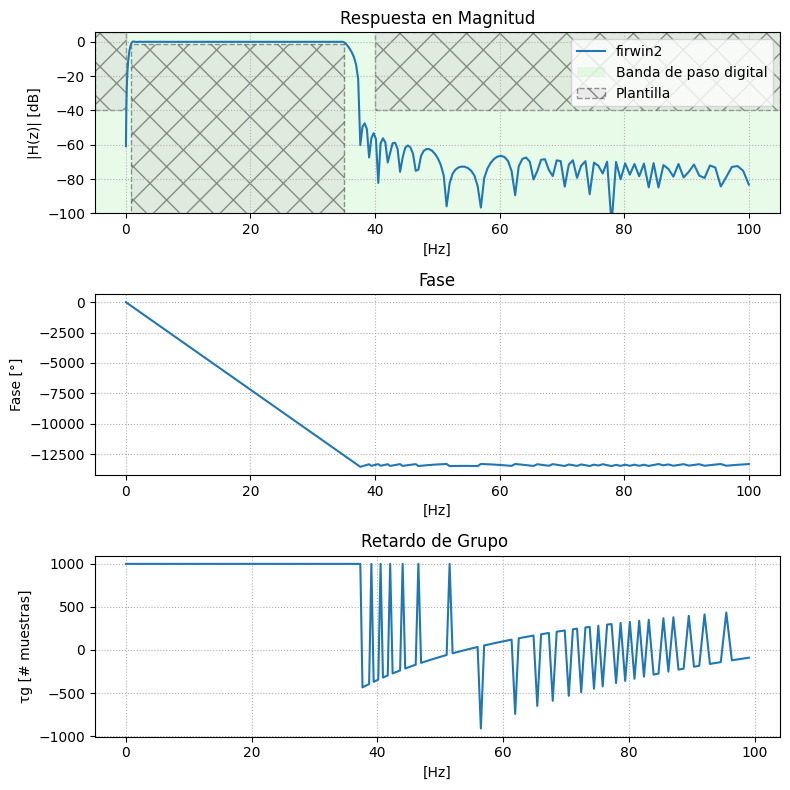

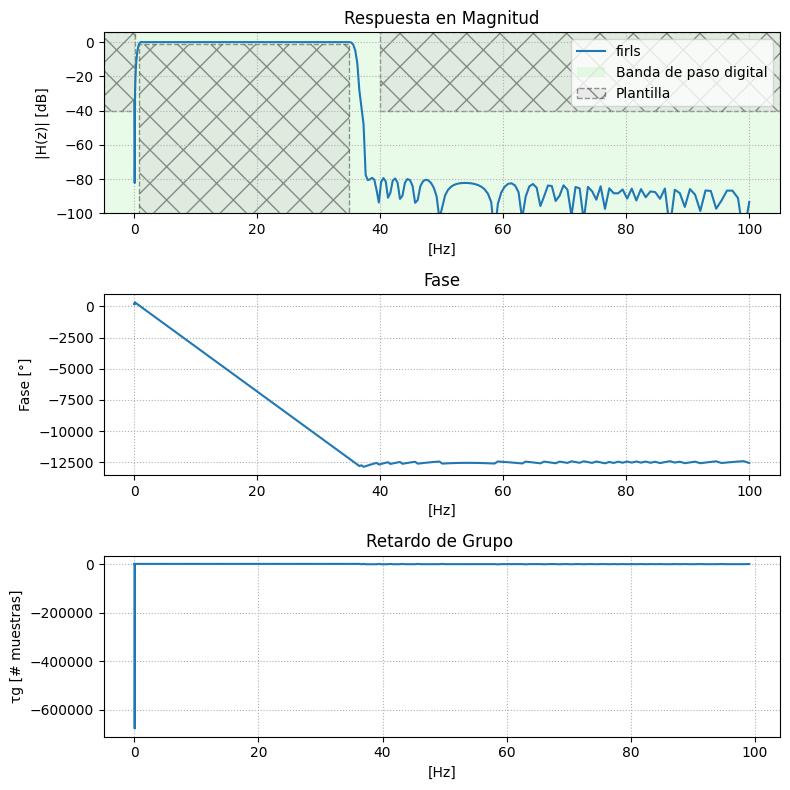

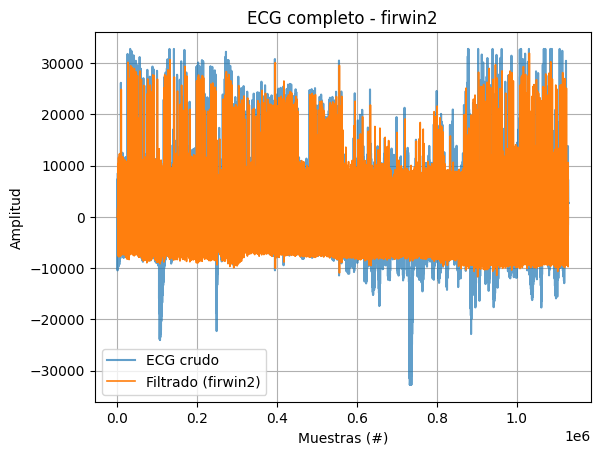

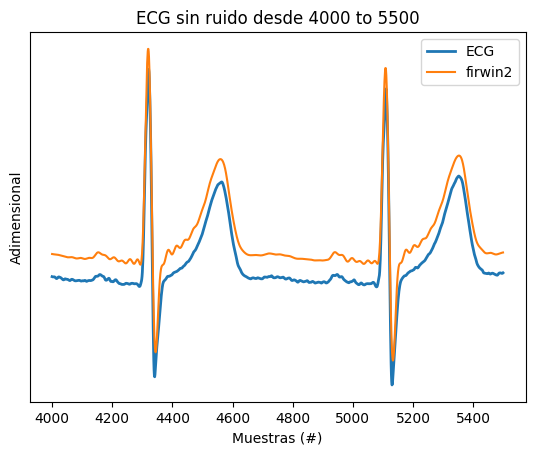

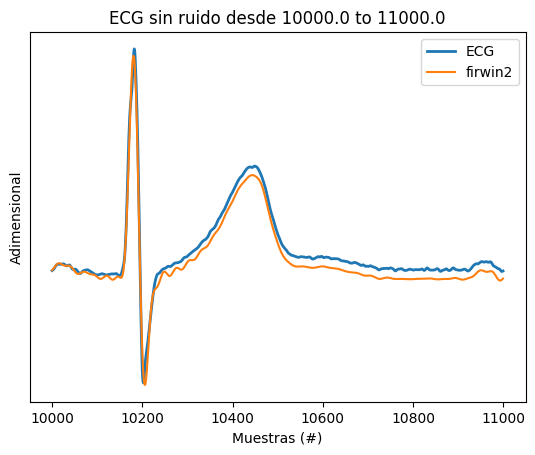

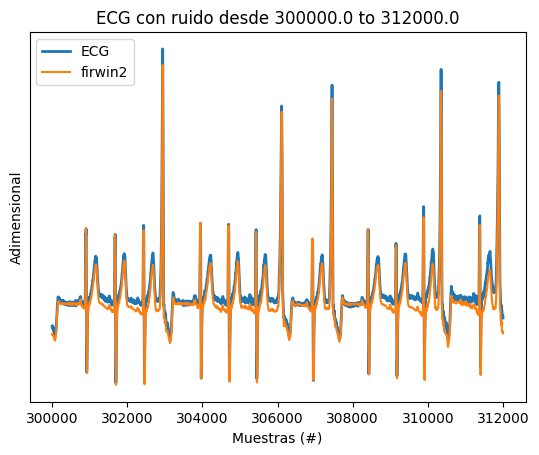

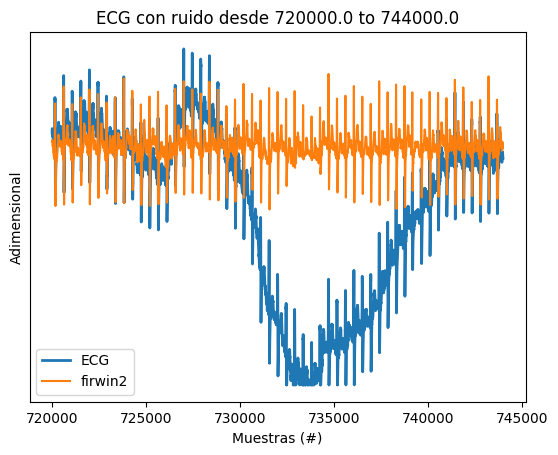

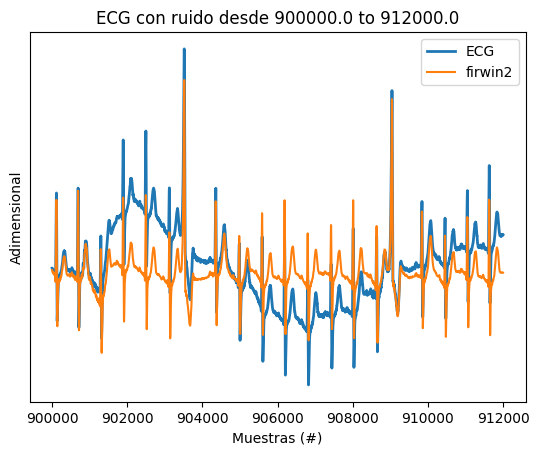

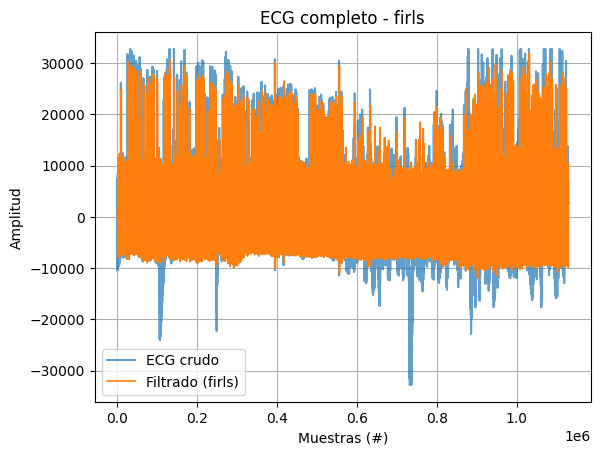

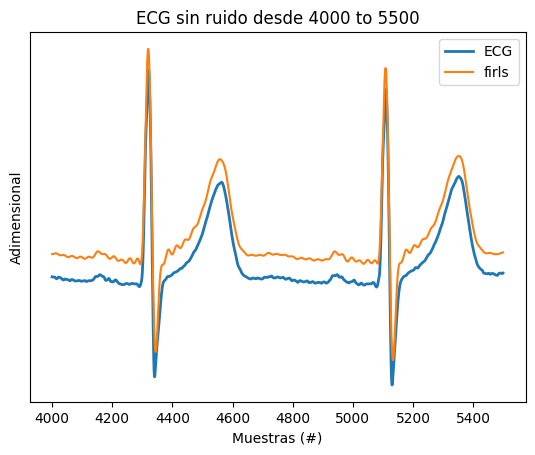

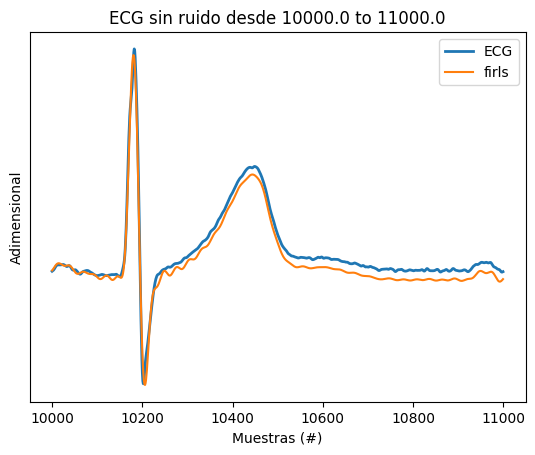

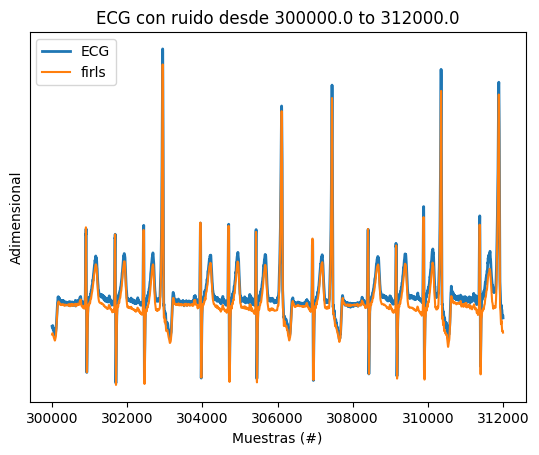

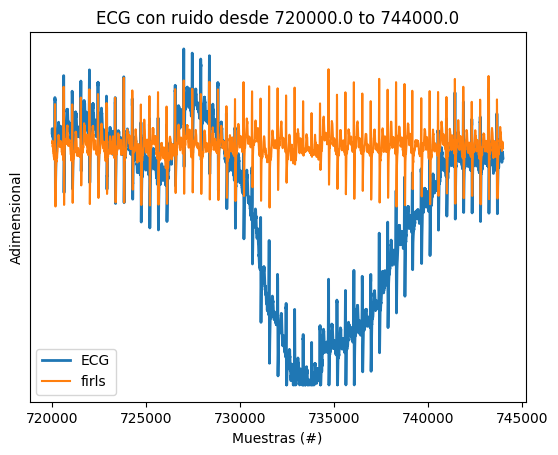

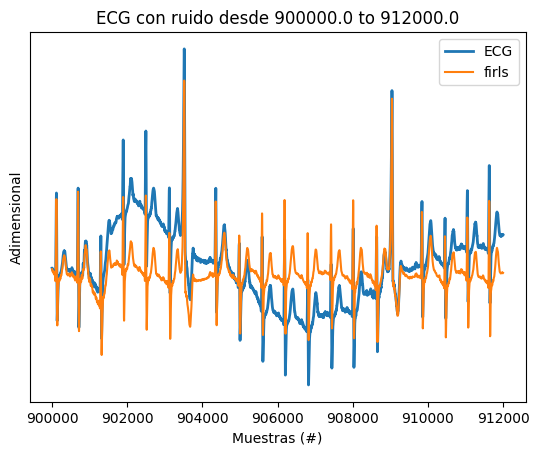

In [12]:
def filtro_FIR(fs, wp, ws, alpha_p, alpha_s, metodo='firwin2'):
    
    # frecuencias= np.sort(np.concatenate(0, wp,ws, fs/2))
    #frecuencias= np.sort(np.concatenate(((0,fs/2), wp,ws)))
    frecuencias = [0, ws_fir[0], wp_fir[0], wp_fir[1], ws_fir[1], fs/2]

    deseado = [0,0,1,1,0,0]
    cant_coef = 2001 if metodo == 'firwin2' else 1999  # impar para fase lineal
    retardo = (cant_coef-1)//2 
    peso = [12,4,4]

        
    # --- Diseño ---
    if metodo == 'firwin2':
        b = firwin2(numtaps=cant_coef, freq=frecuencias, gain=deseado, window='boxcar', fs=fs)
    elif metodo == 'firls':
        b = firls(numtaps=cant_coef, bands=frecuencias, desired=deseado, fs=fs, weight= peso)
    else:
        raise ValueError("Método inválido. Usá 'firwin2' o 'firls'.")
    
    
    # --- Respuesta en frecuencia ---
    w, h= freqz(b, worN = np.logspace(-2, 2, 1000), fs = fs) #calcula rta en frq del filtro, devuelve w y vector de salida (h es numero complejo)    
    fase = np.unwrap(np.angle(h)) 
    w_rad = 2*np.pi*w/fs
    gd = -np.diff(fase) / np.diff(w_rad) #retardo de grupo [rad/rad]
    
    # --- Polos y ceros ---
    
    z, p, k = signal.sos2zpk(signal.tf2sos(b,a= 1)) #ubicacion de polos y ceros, z=ubicacion de ceros(=0), p=ubicacion polos, k
    
    # --- Gráficas ---
    plt.figure(figsize=(8,8))
    
    # Magnitud
    
    plt.subplot(3,1,1)
    plt.plot(w, 20*np.log10(np.maximum(np.abs(h), 1e-10)), label = metodo)
    plot_plantilla(filter_type = 'bandpass' , fpass = (0.8, 35), ripple = alpha_p_fir*2 , fstop = (0.1, 40), attenuation = alpha_s_fir*2, fs = fs)
    plt.title('Respuesta en Magnitud')
    plt.ylabel('|H(z)| [dB]')
    plt.xlabel('[Hz]')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    # Fase
    plt.subplot(3,1,2)
    plt.plot(w, np.degrees(fase))
    plt.title('Fase')
    plt.ylabel('Fase [°]')
    plt.xlabel('[Hz]')
    plt.grid(True, which='both', ls=':')
    
    # Retardo de grupo
    plt.subplot(3,1,3)
    plt.plot(w[:-1], gd)
    plt.title('Retardo de Grupo ')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('τg [# muestras]')
    plt.xlabel('[Hz]')
    plt.grid(True, which='both', ls=':')

    plt.tight_layout()
    plt.show()
    return b, retardo

def filtrar_FIR_ECG(b, nombre_filtro, ecg, fs, retardo):

    ecg_filt = signal.lfilter(b = b, a = 1, x = ecg)

    plt.figure()
    plt.plot(ecg, label='ECG crudo', alpha=0.7)
    plt.plot(ecg_filt, label=f'Filtrado ({nombre_filtro})', linewidth=1.2)
    plt.title(f'ECG completo - {nombre_filtro}')
    plt.xlabel('Muestras (#)')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.grid(True)
    plt.show()

    #################################
    # Regiones de interés sin ruido #
    #################################
    
    cant_muestras = len(ecg_one_lead)
    
    regs_interes = (
            [4000, 5500], # muestras
            [10e3, 11e3], # muestras
            )
     
    for ii in regs_interes:
       
        # intervalo limitado de 0 a cant_muestras
        zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
       
        plt.figure()
        plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=2)
        plt.plot(zoom_region, ecg_filt[zoom_region + retardo], label=nombre_filtro)

        plt.title('ECG sin ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
        plt.ylabel('Adimensional')
        plt.xlabel('Muestras (#)')
       
        axes_hdl = plt.gca()
        axes_hdl.legend()
        axes_hdl.set_yticks(())
               
        plt.show()
     
    #################################
    # Regiones de interés con ruido #
    #################################
     
    regs_interes = (
            np.array([5, 5.2]) *60*fs, # minutos a muestras
            np.array([12, 12.4]) *60*fs, # minutos a muestras
            np.array([15, 15.2]) *60*fs, # minutos a muestras
            )
     
    for ii in regs_interes:
       
        # intervalo limitado de 0 a cant_muestras
        zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
       
        plt.figure()
        plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=2)
        plt.plot(zoom_region, ecg_filt[zoom_region + retardo], label=nombre_filtro)
       
        plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
        plt.ylabel('Adimensional')
        plt.xlabel('Muestras (#)')
       
        axes_hdl = plt.gca()
        axes_hdl.legend()
        axes_hdl.set_yticks(())
               
        plt.show()
    
# --- Loop para comparar FIRs ---
FIR = {}
metodos = ['firwin2', 'firls']
for metodo in metodos:
    FIR[metodo] = filtro_FIR(fs=fs, wp=wp_fir, ws=ws_fir, alpha_p=alpha_p_fir, alpha_s=alpha_s_fir, metodo=metodo)

# Aplicar y graficar ECG filtrado
for metodo, (b, retardo) in FIR.items():
    filtrar_FIR_ECG(b, metodo, ecg_one_lead, fs_ecg, retardo)

## Análisis del filtro FIR por método de ventanas

El primer filtro FIR se diseñó con el método de ventanas utilizando *firwin2*, con un orden de 2001 coeficientes y banda pasante aproximadamente entre 1 y 35 Hz. La respuesta en frecuencia, la fase y el efecto sobre distintos tramos del ECG se resumen a continuación.

#### Respuesta en magnitud

En el gráfico se observa que:

- La banda de paso digital se mantiene prácticamente plana ($\approx 0 dB$) desde 1 Hz hasta unos 35 Hz, cumpliendo cualitativamente con la plantilla de diseño impuesta.

- A partir de $\approx 35–40 Hz$ la magnitud cae bruscamente, alcanzando atenuaciones del orden de –60 dB o menores en las frecuencias más altas.

En conjunto, la respuesta muestra que el filtro se comporta como un pasabanda para el ECG, preservando el contenido fisiológico principal y atenuando tanto la deriva de baja frecuencia como el ruido de alta frecuencia.

#### Fase y retardo de grupo

La fase del filtro decrece casi linealmente en la banda de paso, lo que es consistente con el diseño FIR de fase lineal (orden impar). En el gráfico de retardo de grupo se observa:

- Un retardo prácticamente constante en la banda de paso, cercano a la mitad del número de coeficientes (≈ 1000 muestras), tal como se espera para un FIR lineal.

- Fuera de la banda de paso aparecen oscilaciones grandes del retardo de grupo, pero estas ocurren en frecuencias donde la magnitud del filtro ya es muy baja, por lo que no afectan de manera significativa a la señal filtrada.

#### Efecto sobre tramos sin ruido

En los tramos seleccionados como (alrededor de las muestras 4000–5500 y 10000–11000), la comparación entre el ECG crudo y la señal filtrada muestra que:

- La morfología de los complejos QRS se conserva de forma adecuada.

- Las ondas P y T se ven ligeramente más suaves, lo que es coherente con la eliminación de algo de contenido de muy baja y muy alta frecuencia, pero sin perder su forma global.

- El nivel isoeléctrico se vuelve más estable y menos ruidoso.

Esto sugiere que el filtro es bastante inocuo en regiones donde la señal ya era relativamente limpia.

#### Efecto sobre tramos con ruido

En los tramos identificados con ruido (alrededor de 300000–312000, 720000–744000 y 900000–912000 muestras), se observa que:

- Cuando hay ruido de alta frecuencia superpuesto a los latidos, la señal filtrada presenta complejos QRS mucho más nítidos y un nivel de ruido de fondo sensiblemente menor.

- En regiones con gran movimiento de línea de base, la versión filtrada reduce de manera clara las variaciones lentas, llevando el trazado alrededor de un nivel isoeléctrico más estable.

- En las zonas más contaminadas aún quedan pequeñas irregularidades en las mesetas entre latidos, pero la forma de los QRS es sustancialmente más limpia que en la señal original.

En síntesis, el filtro por ventanas logra reducir tanto la deriva de baja frecuencia como el ruido de alta frecuencia, sin degradar la información relevante del ECG.


## Análisis del filtro FIR por cuadrados mínimos (firls)

El segundo filtro FIR se diseñó mediante el método de cuadrados mínimos utilizando la función *firls* de *SciPy*. Este método ajusta la respuesta del filtro minimizando el error cuadrático entre la plantilla objetivo y la respuesta real, permitiendo un control más preciso sobre el ripple en cada banda mediante ponderaciones específicas. A continuación se analizan su respuesta en frecuencia, comportamiento temporal y desempeño sobre distintas regiones del ECG.

#### Respuesta en magnitud

En la figura se observa que:

- La banda de paso ($\approx 1–35 Hz$) se ajusta de manera bastante plana, con una variación menor que la observada en *firwin2*. Esto es coherente con el método de cuadrados mínimos, que suele minimizar más eficazmente el ripple en la banda de paso.

- La transición hacia la banda de rechazo alta ($\approx35–40 Hz$) es abrupta y la atenuación posterior supera ampliamente los –80 dB, mostrando una supresión efectiva del ruido muscular.

- En la banda de bajas frecuencias (< 1 Hz) el filtro atenúa fuertemente, cumpliendo con el objetivo de eliminar la deriva de línea de base.

En resumen, firls reproduce la plantilla de forma más ajustada que firwin2, especialmente en términos de ripple.

#### Fase y retardo de grupo

La fase presenta un comportamiento prácticamente lineal a lo largo de la banda útil, como se espera de un FIR simétrico.
El retardo de grupo confirma:

- Un retardo constante dentro de la banda de paso, correspondiente a la mitad del número de coeficientes.

- Comportamiento errático fuera de la banda donde el módulo del filtro es casi nulo, lo cual no afecta el ECG filtrado.

Con ello se garantiza que la forma del latido no se deforma dentro del rango fisiológico del ECG.

#### Efecto sobre regiones sin ruido

En los segmentos sin ruido (4000–5500 y 10000–11000 muestras), la señal filtrada muestra:

- Conservación clara de la morfología del complejo QRS, manteniendo la pendiente ascendente y descendente.

- Un suavizado un poco más pronunciado de la onda T respecto a *firwin2*.

- Una línea isoeléctrica más estable y menos contaminada por fluctuaciones lentas.

Esto confirma que firls es inocuo en zonas limpias y que no introduce oscilaciones artificiales.

#### Efecto sobre regiones con ruido

En los tramos con ruido (alrededor de 3000000–312000, 720000–744000 y 900000–912000):

- El filtro reduce de manera notable el contenido de alta frecuencia, dejando los complejos QRS definidos incluso en zonas con fuerte ruido muscular.

- En presencia de ruido de línea de base, la salida filtrada elimina casi por completo la deriva, manteniendo un nivel isoeléctrico uniforme.

- Comparado con *firwin2*, *firls* tiende a producir un filtrado ligeramente más agresivo, especialmente visible en los segmentos con ruido extremo. Esto hace que la señal filtrada se vea más “limpia”, pero también más suavizada.

En general, firls ofrece un excelente compromiso entre atenuación del ruido y preservación de morfología.

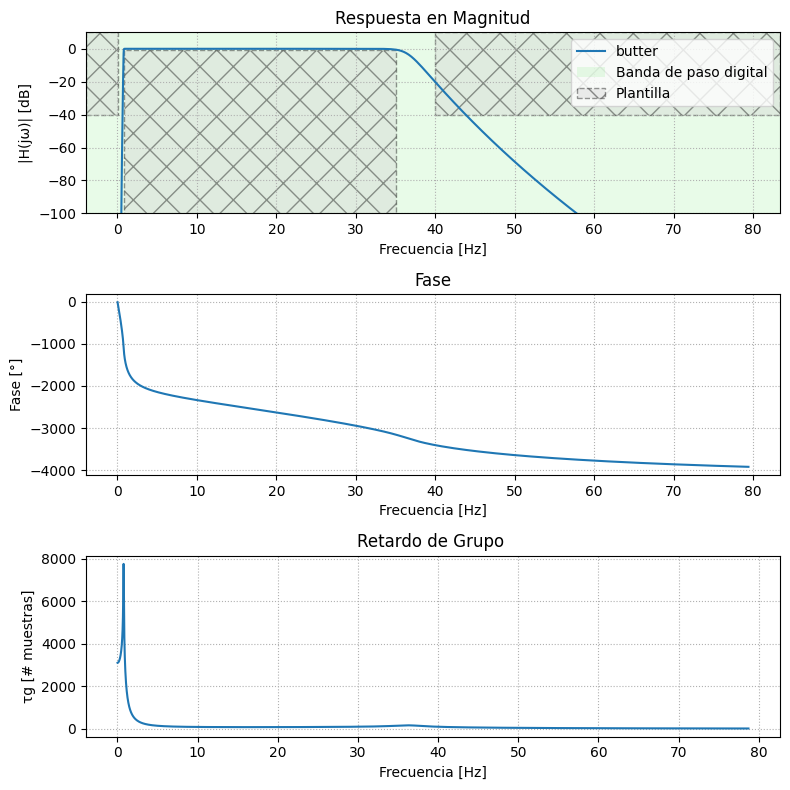

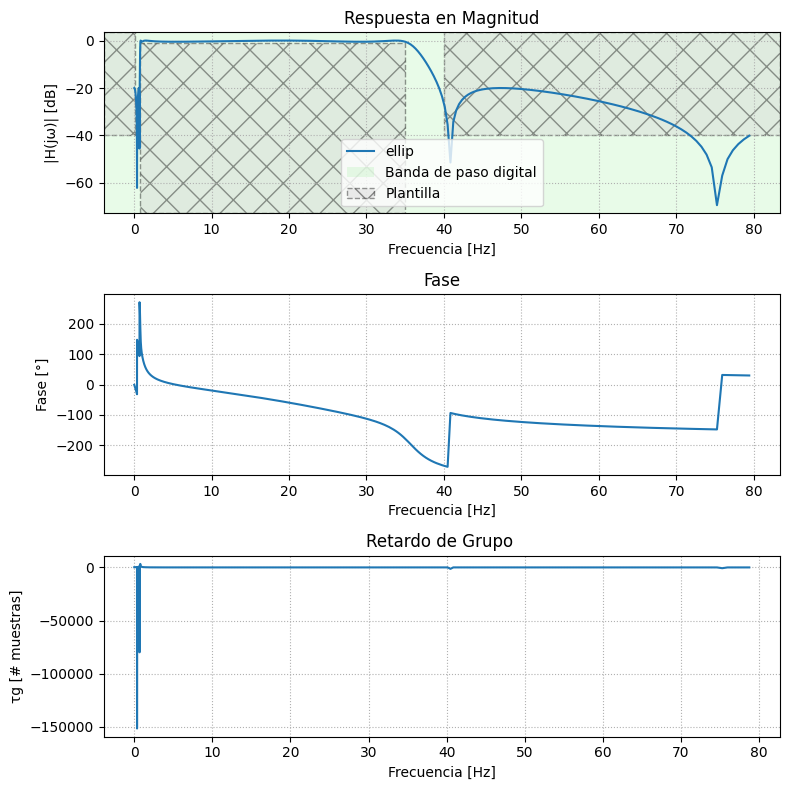

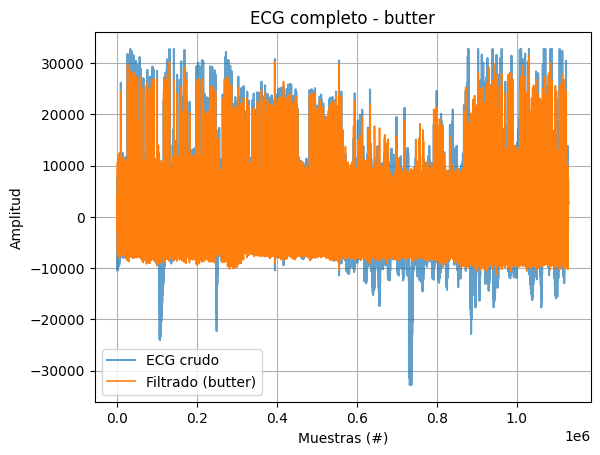

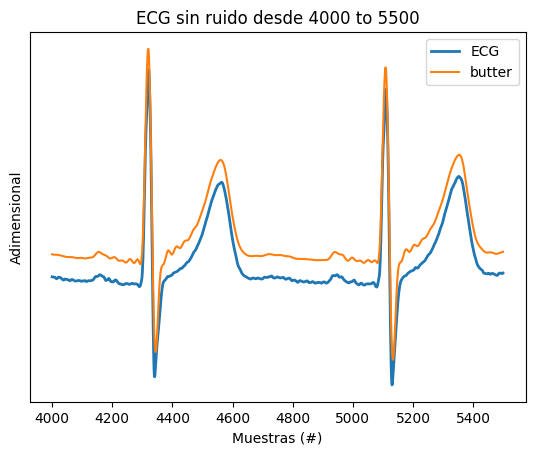

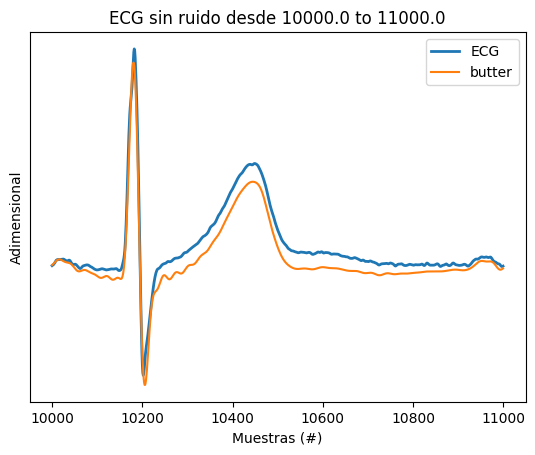

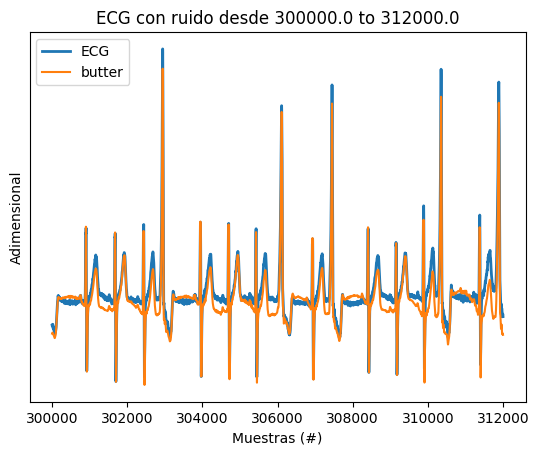

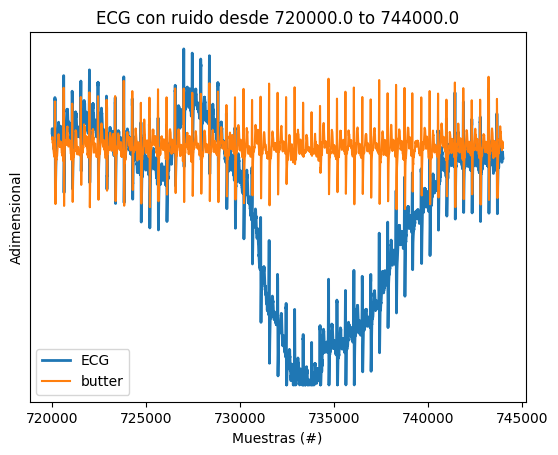

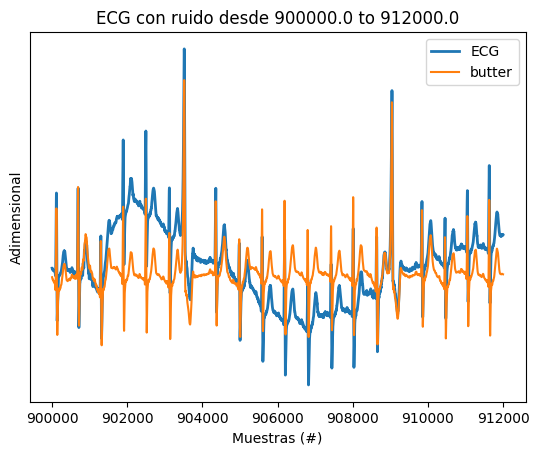

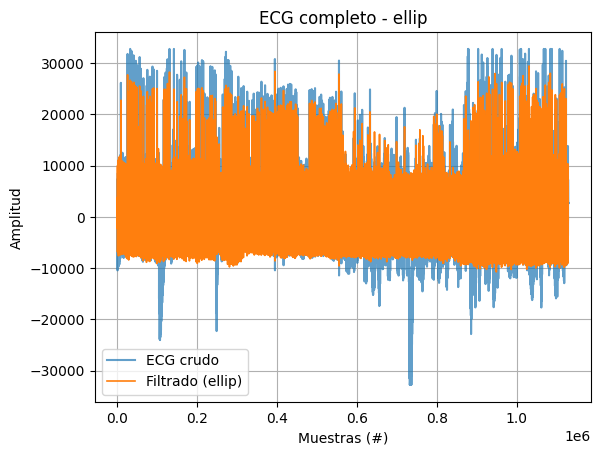

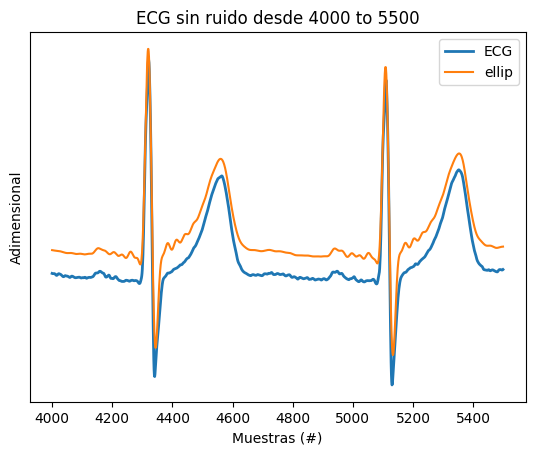

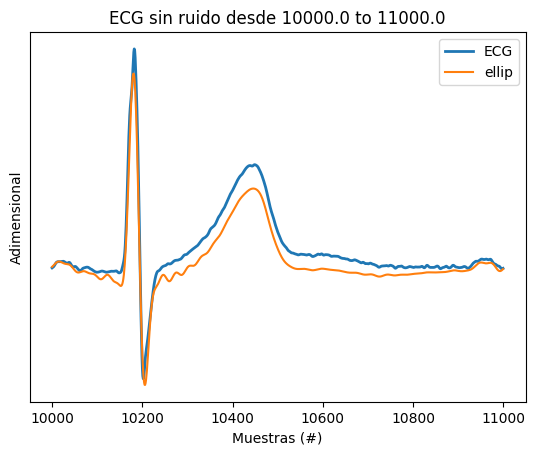

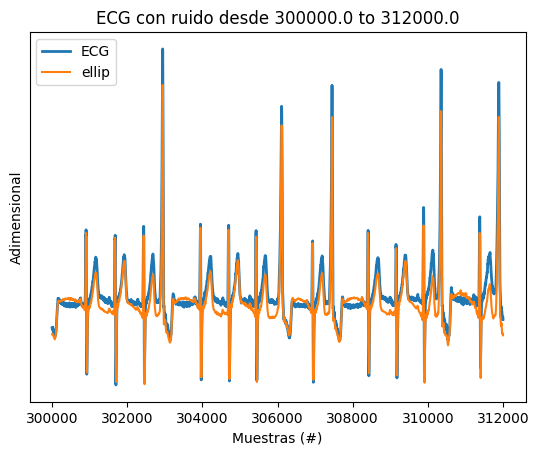

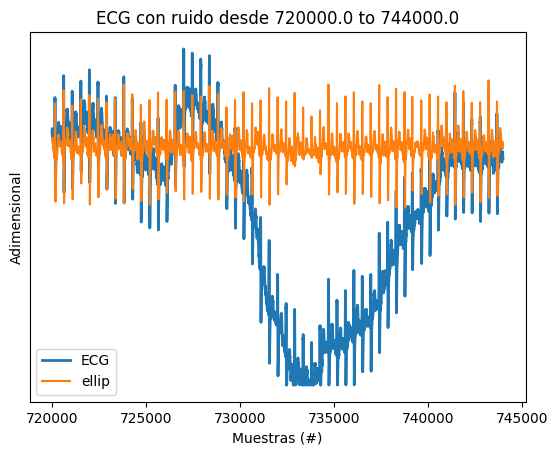

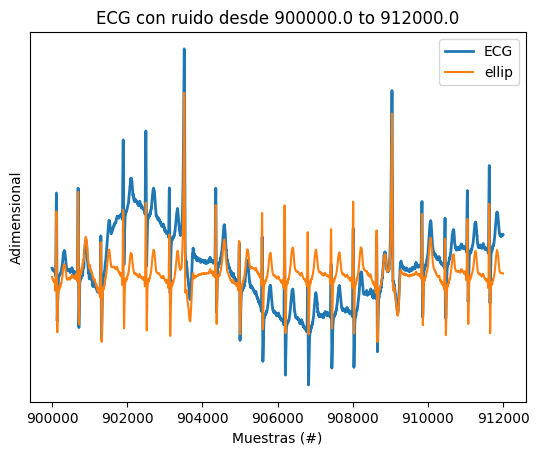

In [17]:
fs = 1000
wp = (0.8, 35) #freq de corte/paso (rad/s)
ws = (0.1, 40) #freq de stop/detenida (rad/s)

#si alpha_p es =3 -> max atenuacion, butter

alpha_p = 1/2 #atenuacion de corte/paso, alfa_max, perdida en banda de paso 
alpha_s = 40/2 #atenuacion de stop/detenida, alfa_min, minima atenuacion requerida en banda de paso 

def filtro_IIR(fs, wp, ws, alpha_p, alpha_s, ftype): 
    
    mi_sos = signal.iirdesign(wp = wp, ws = ws, gpass = alpha_p, gstop = alpha_s, analog = False, ftype = ftype, output ='sos', fs=fs) #devuelve dos listas de coeficientes, b para P y a para Q
    
    # Respuesta en frecuencia
    w, h= signal.freqz_sos(mi_sos, worN = np.logspace(-2, 1.9, 1000), fs = fs) #calcula rta en frq del filtro, devuelve w y vector de salida (h es numero complejo)
    fase = np.unwrap(np.angle(h)) #unwrap hace grafico continuo
    w_rad = w / (fs / 2) * np.pi
    gd = -np.diff(fase) / np.diff(w_rad) 
    
    # --- Polos y ceros ---
    z, p, k = signal.sos2zpk(mi_sos) #ubicacion de polos y ceros, z=ubicacion de ceros(=0), p=ubicacion polos, k
    
    # --- Gráficas ---
    #plt.figure(figsize=(12,10))
    
    # Magnitud
    plt.figure(figsize=(8, 8))
    plt.subplot(3,1,1)
    plt.plot(w, 20 * np.log10(np.maximum(abs(h), 1e-10)), label = ftype)
    plot_plantilla(filter_type = 'bandpass' , fpass = wp, ripple = alpha_p*2 , fstop = ws, attenuation = alpha_s*2, fs = fs)
    plt.title('Respuesta en Magnitud')
    plt.ylabel('|H(jω)| [dB]')
    plt.xlabel('Frecuencia [Hz]')
    plt.grid(True, which='both', ls=':')
    plt.legend()

    # Fase
    plt.subplot(3,1,2)
    plt.plot(w, np.degrees(fase))
    plt.title('Fase')
    plt.ylabel('Fase [°]')
    plt.xlabel('Frecuencia [Hz]')
    plt.grid(True, which='both', ls=':')
    
    # Retardo de grupo
    plt.subplot(3,1,3)
    plt.plot(w[:-1], gd)
    plt.title('Retardo de Grupo ')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('τg [# muestras]')
    plt.grid(True, which='both', ls=':')
    
    plt.tight_layout()
    plt.show()
    
    return mi_sos

def filtrar_IIR_ECG(mi_sos, nombre_filtro, ecg=ecg_one_lead, fs=fs_ecg):
    ecg_filt = signal.sosfiltfilt(mi_sos, ecg)

    plt.figure()
    plt.plot(ecg, label='ECG crudo', alpha=0.7)
    plt.plot(ecg_filt, label=f'Filtrado ({nombre_filtro})', linewidth=1.2)
    plt.title(f'ECG completo - {nombre_filtro}')
    plt.xlabel('Muestras (#)')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.grid(True)
    plt.show()

    #################################
    # Regiones de interés sin ruido #
    #################################
    
    cant_muestras = len(ecg_one_lead)
    
    regs_interes = (
            [4000, 5500], # muestras
            [10e3, 11e3], # muestras
            )
     
    for ii in regs_interes:
       
        # intervalo limitado de 0 a cant_muestras
        zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
       
        plt.figure()
        plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=2)
        plt.plot(zoom_region, ecg_filt[zoom_region], label=nombre_filtro)
        #plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')
       
        plt.title('ECG sin ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
        plt.ylabel('Adimensional')
        plt.xlabel('Muestras (#)')
       
        axes_hdl = plt.gca()
        axes_hdl.legend()
        axes_hdl.set_yticks(())
               
        plt.show()
     
    #################################
    # Regiones de interés con ruido #
    #################################
     
    regs_interes = (
            np.array([5, 5.2]) *60*fs, # minutos a muestras
            np.array([12, 12.4]) *60*fs, # minutos a muestras
            np.array([15, 15.2]) *60*fs, # minutos a muestras
            )
     
    for ii in regs_interes:
       
        # intervalo limitado de 0 a cant_muestras
        zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
       
        plt.figure()
        plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=2)
        plt.plot(zoom_region, ecg_filt[zoom_region], label=nombre_filtro)
        # plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')
       
        plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
        plt.ylabel('Adimensional')
        plt.xlabel('Muestras (#)')
       
        axes_hdl = plt.gca()
        axes_hdl.legend()
        axes_hdl.set_yticks(())
               
        plt.show()

#### Comparo distintos IIR 
IIR = {}
tipos = ['butter', 'ellip']  # 'ellip' = Cauer
for tipo in tipos:
    IIR[tipo] = filtro_IIR(fs = fs, wp = wp, ws = ws, alpha_p = alpha_p, alpha_s = alpha_s, ftype = tipo)
        

# Aplicar y graficar ECG filtrado
for tipo, sos in IIR.items():
    filtrar_IIR_ECG(sos, tipo)  

## Análisis del filtro IIR Butterworth

El primer filtro IIR se diseñó con la aproximación de Butterworth, que se caracteriza por presentar módulo de máxima planicidad en la banda de paso. El filtro se implementó en forma de secciones de segundo orden (SOS), aplicadas con *sosfiltfilt* para obtener filtrado de fase cero en la señal de ECG.

#### Respuesta en magnitud

En el gráfico se observa que:

- La banda de paso entre aproximadamente 1 y 40 Hz se mantiene casi perfectamente plana alrededor de 0 dB, sin ondulaciones apreciables, cumpliendo con la propiedad de máxima planicidad de Butterworth.

- En bajas frecuencias, por debajo de 1 Hz, la magnitud cae fuertemente, lo que permite eliminar la deriva de línea de base.

- A partir de ~40 Hz la magnitud empieza a disminuir de forma monótona, alcanzando atenuaciones superiores a –60 dB antes de 60 Hz, lo que asegura una buena supresión del ruido muscular y otras interferencias de alta frecuencia.

En conjunto, el filtro se comporta como un pasabanda suave, con transiciones menos abruptas que las del FIR, pero suficiente para el rango de interés del ECG.

#### Fase y retardo de grupo

La fase del Butterworth es claramente no lineal en toda la banda de paso, y esto también se refleja en el gráfico de retardo de grupo, donde:

- El retardo es grande y muy variable a frecuencias cercanas a 0 Hz.

- En la banda de paso ($\approx1–40 Hz$) el retardo de grupo disminuye, pero sigue siendo frecuencia-dependiente.

Sin embargo, en la implementación sobre el ECG se utilizó sosfiltfilt, que aplica el filtro hacia adelante y hacia atrás. Esto compensa la fase no lineal y produce una respuesta de fase efectiva aproximadamente nula, manteniendo la morfología de los latidos sin desplazamientos ni deformaciones temporales apreciables.

#### Efecto sobre regiones sin ruido

En los segmentos considerados (muestras 4000–5500 y 10000–11000), la comparación entre el ECG crudo y la señal filtrada muestra que:

- Los complejos QRS se conservan adecuadamente, con picos altos y pendientes pronunciadas.

- La onda T aparece algo más suavizada y con ligera reducción de amplitud, efecto coherente con el recorte suave de altas frecuencias propio del filtro.

- El nivel isoeléctrico entre latidos se vuelve más estable y con menos oscilaciones de baja frecuencia.

En resumen, el Butterworth es bastante inocuo en zonas limpias, aunque se nota un suavizado algo mayor de las componentes lentas respecto de los FIR.

#### Efecto sobre regiones con ruido

En las regiones con ruido (alrededor de 300000–312000, 720000–744000 y 900000–912000 muestras) se observa que:

- Frente a ruido de alta frecuencia superpuesto a los latidos, la señal filtrada presenta complejos QRS más nítidos y un fondo menos ruidoso, aunque con cierta reducción de amplitud global.

- En tramos dominados por movimiento de línea de base (por ejemplo cerca de 720000–744000), el Butterworth elimina casi por completo la gran excursión lenta presente en el ECG crudo, centrando el trazado alrededor de un nivel isoeléctrico estable.

- En zonas con ruido intenso y latidos superpuestos, el filtro tiende a producir una señal algo “más comprimida” que los FIR, producto de su pendiente de magnitud más suave y de la atenuación repartida en todo el pasabanda.

En general, el Butterworth logra una buena supresión de la deriva de base y del ruido muscular, preservando los QRS pero con un suavizado ligeramente superior de las componentes de baja y media frecuencia.

## Análisis del filtro IIR Elíptico (Cauer)

El segundo filtro IIR se diseñó utilizando la aproximación Elíptica (Cauer), caracterizada por: Ripple controlado en banda de paso, Ripple en banda de detención, y la transición más abrupta posible para un mismo orden comparado con Butterworth o Chebyshev.
Se implementó en formato SOS y se aplicó al ECG mediante *sosfiltfilt* para garantizar fase cero y evitar distorsiones temporales.

#### Respuesta en magnitud

En el gráfico de magnitud se observan características típicas de la aproximación elíptica:

- La banda de paso (≈ 1–40 Hz) presenta leve ripple, producto del diseño, pero se mantiene cercana a 0 dB.

- La transición hacia la banda de rechazo alta es extremadamente abrupta, mucho más que en el Butterworth o los FIR.

- Aparecen notches (atenuaciones muy profundas) cerca de 45 Hz y 75–80 Hz, que son consecuencia del ripple permitido en la stopband. Esto es propio de los filtros elípticos.

- La banda de bajas frecuencias (< 1 Hz) está fuertemente atenuada.

La respuesta demuestra que el filtro cumple la plantilla con la pendiente más pronunciada de todos los filtros, lo que maximiza la separación entre señal y ruido.

#### Fase y retardo de grupo

La fase es altamente no lineal y muestra discontinuidades visibles, así como el retardo de grupo. El retardo presenta picos enormes a bajas frecuencias y oscilaciones irregulares en toda la banda. Esto sería un problema si se aplicara el filtro en forma causal, pero al usar *sosfiltfilt* el efecto de la fase desaparece y la señal final queda sin distorsión temporal (fase cero).

#### Efecto sobre regiones sin ruido

En los segmentos limpios (4000–5500 y 10000–11000):

- Los QRS se conservan, incluso más nítidos que con Butterworth.

- La onda T aparece más reducida y suavizada, consecuencia del recorte agresivo de altas frecuencias dentro del pasabanda.

- La línea isoeléctrica queda estable, con muy poca oscilación.


#### Efecto sobre regiones con ruido

En los tramos contaminados (300000–312000, 720000–744000, 900000–912000):

- El filtro elimina fuertemente el ruido de alta frecuencia, dejando los QRS extremadamente limpios.

- En zonas con deriva o movimiento del electrodo, el elíptico aplasta casi por completo las variaciones lentas.

- En regiones extremadamente ruidosas, la señal filtrada parece “excesivamente comprimida”, perdiendo algo de amplitud general, especialmente en las ondas T y en los segmentos ST.

Comparado con Butterworth, el Elíptico suprime más ruido, pero a costa de una distorsión leve del relieve fino del ECG. Este filtro es el más eficiente en términos de eliminación de interferencias, pero también el más propenso a suavizar partes menos energéticas del latido.


# Conclusión

A lo largo de esta tarea se diseñaron y evaluaron distintos filtros digitales con el objetivo de obtener una señal de ECG semejante al latido promedio, sin deriva de línea de base y con el ruido de alta frecuencia atenuado. La plantilla de diseño establecida permitió garantizar que los filtros mantuvieran la información fisiológica relevante y suprimieran las principales fuentes de contaminación.

Los resultados muestran que los filtros **FIR** fueron los más conservadores respecto de la morfología del ECG, especialmente en la banda de paso. El **FIR por ventanas** (*firwin2*) ofrece un comportamiento suave y estable, con fase lineal y mínima distorsión; mientras que el **FIR por cuadrados mínimos** (*firls*) logra un mejor ajuste a la plantilla, con menor ripple y un filtrado más eficiente del ruido, aunque con un leve suavizado adicional de las ondas P y T. Ambos **FIR** mantienen prácticamente intacto el contorno de los complejos QRS, incluso en zonas con ruido, a costa de un mayor orden y retardo constante.

En cuanto a los filtros **IIR**, el **Butterworth** se comporta como una alternativa más compacta en orden y con una banda de paso muy plana. Combinado con *sosfiltfilt*, que elimina la distorsión de fase, preserva adecuadamente la forma de los latidos, aunque con un filtrado algo más agresivo que los **FIR** en las regiones suaves del ECG. Finalmente, el filtro **Elíptico (Cauer)** resultó ser el más eficiente en términos de separación entre señal y ruido: su transición abrupta y su elevada atenuación permiten limpiar la señal incluso en los tramos más contaminados. Sin embargo, esta ganancia en selectividad se traduce en una mayor pérdida de detalle en ondas de baja amplitud, lo que lo convierte en el filtro menos conservador del conjunto.

En síntesis, todos los filtros cumplen la plantilla y mejoran significativamente la calidad del registro, pero con compromisos distintos.

El análisis integral permite concluir que la elección del filtro depende del balance deseado entre preservación morfológica y agresividad en la supresión del ruido. Para aplicaciones donde la forma del ECG debe mantenerse con la menor distorsión posible, los filtros **FIR** son los más adecuados, mientras que para escenarios con interferencias severas, los **IIR** —especialmente el Elíptico— ofrecen una alternativa más eficaz.


## Autoevaluacion

*Indicar una opción (marcada con negrita):*

1. **Resolví la tarea con seguridad**
2. Resolví la tarea, pero tengo dudas
3. Resolví la tarea,pero no entendí bien
4. No pude resolverla y no entendí


Responder:

*¿Qué aprendiste al hacer esta tarea?*

En esta TS aprendimos a realizar de diseño de plantilla desde cero, ajustando los parametros de acuerdo a los requerimientos necesarios. Tambien pudimos implementar cuatro filtros distintos sobre una misma señal y analizar su accionar sobre ella.

*¿Qué te quedó claro? ¿Qué te sigue costando?*

Se comprendio como la variacion en los parametros influye en el diseño del filtro y como la decision de que filtro usar tiene consecuencias sobre la respuesta en magnitud, fase y retardo.

*Indicar si se utilizó IA:*

**Sí, usé chatGPT, Qwen, Deepseek, Gemini, otra.**
No usé IA.
*En caso afirmativo, indicar una opción o varias:*

Escritura

**Código**

**Conceptos teorícos**

**Gráficos**

Conclusiones